
# SC4001 Deep Learning - Group Project #
##  Oxford Flowers 102 Recognition ##

Role: Person A - Data Pipeline & Baseline Model
File: person_a_baseline/baseline_model.ipynb

This notebook contains:
1. Dataset setup and exploration
2. Data augmentation pipeline  
3. Baseline ResNet18 model
4. Training and evaluation
5. Results for team comparison

Team can import the dataloader using:
from person_a_baseline.dataloader import get_flowers_dataloaders

In [ ]:
# ============================================
# Installation & Imports
# ============================================
# Install required packages if needed
# !pip install torch torchvision matplotlib seaborn tqdm

import json
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

# Set style for plots
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

print(f"PyTorch Version: {torch.__version__}")
print(f"TorchVision Version: {torchvision.__version__}")

PyTorch Version: 2.8.0+cpu
TorchVision Version: 0.23.0+cpu


## 🔧 Setup and Configuration

Setting random seeds for reproducibility and checking available compute device (GPU/CPU).

In [2]:
# ============================================
# Set Random Seeds for Reproducibility
# ============================================
def set_seed(seed=42):
	"""Set seeds for reproducibility"""
	random.seed(seed)
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False


set_seed(42)
print("Seeds set for reproducibility")

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
	print(f"GPU: {torch.cuda.get_device_name(0)}")

Seeds set for reproducibility
Using device: cpu


## 📊 Dataset Download and Exploration

Downloading the Oxford Flowers 102 dataset from TorchVision. This dataset contains:
- 102 flower categories
- Images with varied scales, poses, and lighting conditions
- Split into train, validation, and test sets

In [ ]:
# ============================================
# Load Existing Dataset
# ============================================

# Dataset is already downloaded in ../data/flowers-102
data_root = "../data"

# Check if data exists
data_path = os.path.join(data_root, "flowers-102")
if os.path.exists(data_path):
	print(f"Dataset found at: {data_path}")
else:
	print(f"Warning: Dataset not found at {data_path}")

# Load dataset (with download=False since you already have it)
print("Loading Flowers102 dataset...")

# Load test dataset with transforms
test_dataset = datasets.Flowers102(
	root=data_root,
	split="test",
	download=False,  # Changed to False
	transform=transforms.ToTensor(),
)

# Load without transforms for exploration
train_dataset_raw = datasets.Flowers102(
	root=data_root,
	split="train",
	download=False,  # Already False
)

val_dataset_raw = datasets.Flowers102(
	root=data_root,
	split="val",
	download=False,  # Already False
)

# Basic statistics
print("\n" + "=" * 50)
print("DATASET STATISTICS")
print("=" * 50)
print(f"Training samples: {len(train_dataset_raw)}")
print(f"Validation samples: {len(val_dataset_raw)}")
print(f"Test samples: {len(test_dataset)}")
print("Number of classes: 102")
print(f"Samples per class (train): {len(train_dataset_raw) // 102:.0f}")
print(f"Samples per class (val): {len(val_dataset_raw) // 102:.0f}")

# Verify image path
print(f"\nImages location: {os.path.join(data_path, 'jpg')}")

Dataset found at: ../data\flowers-102
Loading Flowers102 dataset...

DATASET STATISTICS
Training samples: 1020
Validation samples: 1020
Test samples: 6149
Number of classes: 102
Samples per class (train): 10
Samples per class (val): 10

Images location: ../data\flowers-102\jpg


## 🌸 Visualize Sample Images

Let's look at some random flower samples from our training set to understand what we're working with.

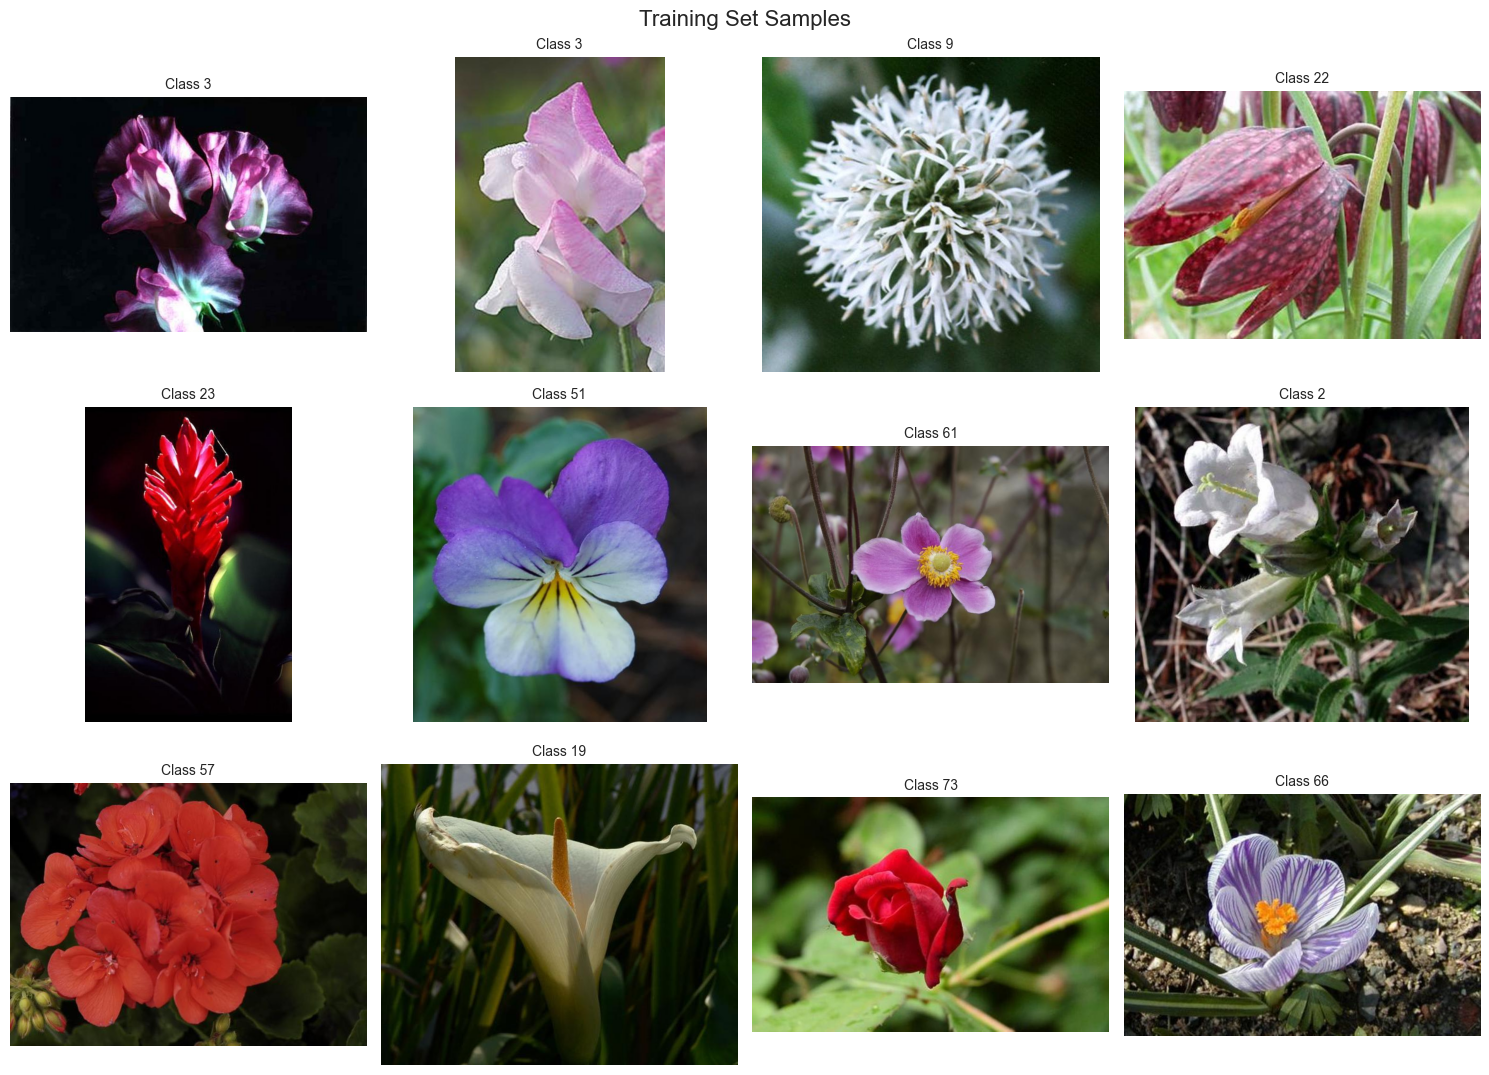

In [5]:
# ============================================
# Visualize Sample Images
# ============================================
def visualize_samples(dataset, num_samples=12, title="Sample Images"):
	"""Visualize random samples from dataset"""
	fig, axes = plt.subplots(3, 4, figsize=(15, 11))
	fig.suptitle(title, fontsize=16)

	indices = random.sample(range(len(dataset)), num_samples)

	for idx, ax in zip(indices, axes.flat):
		img, label = dataset[idx]
		ax.imshow(img)
		ax.set_title(f"Class {label}", fontsize=10)
		ax.axis("off")

	plt.tight_layout()
	plt.show()


visualize_samples(train_dataset_raw, 12, "Training Set Samples")

## 📐 Analyze Image Dimensions

Understanding the size distribution of our images helps us choose appropriate resize parameters.

In [6]:
# ============================================
# Analyze Image Dimensions
# ============================================
print("Analyzing image dimensions...")
widths, heights = [], []
for i in range(min(500, len(train_dataset_raw))):  # Sample 500 images
	img, _ = train_dataset_raw[i]
	widths.append(img.size[0])
	heights.append(img.size[1])

print(f"Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
print(
	f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}"
)

Analyzing image dimensions...
Width  - Min: 500, Max: 857, Mean: 612.9
Height - Min: 500, Max: 993, Mean: 544.0


## 🔄 Data Augmentation and DataLoader

Creating data augmentation pipeline and DataLoader functions. This is the **key deliverable** for the team!

**Training augmentations:**
- Random cropping and resizing
- Horizontal flipping
- Color jittering
- Rotation

**Validation/Test:**
- Only resize and normalize (no augmentation)

In [7]:
# ============================================
# Create DataLoader Functions
# ============================================
def get_data_transforms():
	"""
	Returns data transforms for train and test/val sets

	Train: Data augmentation for better generalization
	Test/Val: Only normalization
	"""

	# ImageNet statistics for normalization (since we use pretrained models)
	normalize = transforms.Normalize(
		mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
	)

	# Training transforms with augmentation
	train_transform = transforms.Compose(
		[
			transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
			transforms.RandomHorizontalFlip(p=0.5),
			transforms.RandomRotation(15),
			transforms.ColorJitter(
				brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1
			),
			transforms.ToTensor(),
			normalize,
		]
	)

	# Validation/Test transforms (no augmentation)
	test_transform = transforms.Compose(
		[
			transforms.Resize(256),
			transforms.CenterCrop(224),
			transforms.ToTensor(),
			normalize,
		]
	)

	return train_transform, test_transform


def get_flowers_dataloaders(batch_size=32, num_workers=4):
	"""
	Create DataLoaders for Flowers102 dataset

	Args:
	    batch_size: Batch size for training
	    num_workers: Number of parallel workers for data loading

	Returns:
	    train_loader, val_loader, test_loader
	"""

	train_transform, test_transform = get_data_transforms()

	# Create datasets with transforms
	train_dataset = datasets.Flowers102(
		root="../data", split="train", transform=train_transform
	)

	val_dataset = datasets.Flowers102(
		root="../data", split="val", transform=test_transform
	)

	test_dataset = datasets.Flowers102(
		root="../data", split="test", transform=test_transform
	)

	# Create dataloaders
	train_loader = DataLoader(
		train_dataset,
		batch_size=batch_size,
		shuffle=True,
		num_workers=num_workers,
		pin_memory=True if torch.cuda.is_available() else False,
	)

	val_loader = DataLoader(
		val_dataset,
		batch_size=batch_size,
		shuffle=False,
		num_workers=num_workers,
		pin_memory=True if torch.cuda.is_available() else False,
	)

	test_loader = DataLoader(
		test_dataset,
		batch_size=batch_size,
		shuffle=False,
		num_workers=num_workers,
		pin_memory=True if torch.cuda.is_available() else False,
	)

	return train_loader, val_loader, test_loader


# Test the dataloader
train_loader, val_loader, test_loader = get_flowers_dataloaders(batch_size=32)
print("\nDataLoader created successfully!")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


DataLoader created successfully!
Train batches: 32
Val batches: 32
Test batches: 193


## 🎨 Visualize Augmented Images

Let's see how our augmentation transforms modify the training images.

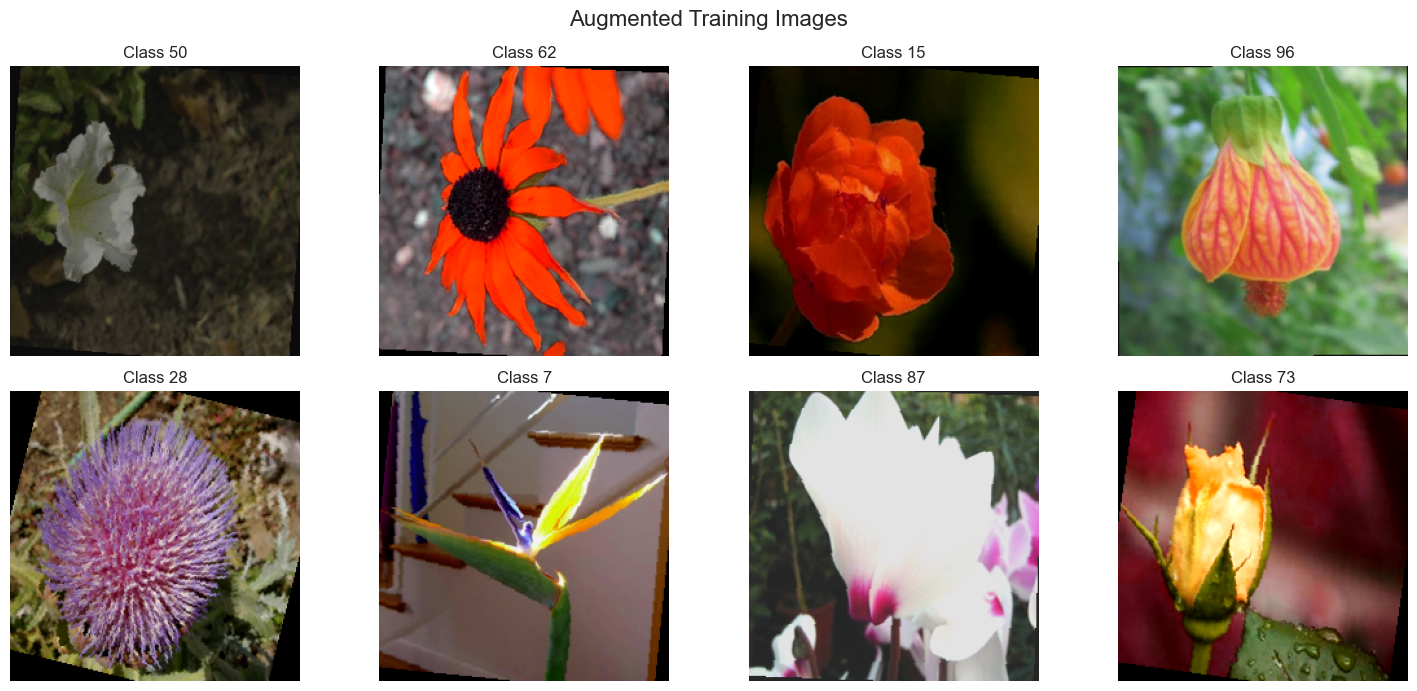

In [7]:
# ============================================
# Visualize Augmented Images
# ============================================
def show_augmented_batch(dataloader):
	"""Show a batch with augmentations applied"""
	images, labels = next(iter(dataloader))

	fig, axes = plt.subplots(2, 4, figsize=(15, 7))
	fig.suptitle("Augmented Training Images", fontsize=16)

	# Denormalize for visualization
	mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
	std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

	for idx, ax in enumerate(axes.flat):
		if idx < len(images):
			img = images[idx]
			img = img * std + mean  # Denormalize
			img = torch.clamp(img, 0, 1)

			ax.imshow(img.permute(1, 2, 0))
			ax.set_title(f"Class {labels[idx].item()}")
			ax.axis("off")

	plt.tight_layout()
	plt.show()


show_augmented_batch(train_loader)

## 🤖 Baseline Model Definition

Using **ResNet18** with transfer learning:
- Pre-trained on ImageNet (1000 classes)
- Modified final layer for 102 flower classes
- ~11.7M parameters

In [ ]:
# ============================================
# Define Baseline Model
# ============================================
def create_baseline_model(num_classes=102, pretrained=True, model_name="resnet18"):
	"""
	Create baseline model using transfer learning

	Args:
	    num_classes: Number of output classes (102 for Flowers)
	    pretrained: Use ImageNet pretrained weights
	    model_name: Model architecture ('resnet18', 'resnet34', 'resnet50')

	Returns:
	    model: PyTorch model ready for training
	"""

	print(f"Creating {model_name} model...")

	if model_name == "resnet18":
		model = models.resnet18(pretrained=pretrained)

	elif model_name == "resnet34":
		model = models.resnet34(pretrained=pretrained)

	elif model_name == "resnet50":
		model = models.resnet50(pretrained=pretrained)

	elif model_name == "resnet101":
		model = models.resnet50(pretrained=pretrained)

	elif model_name == "resnet152":
		model = models.resnet50(pretrained=pretrained)

	else:
		raise ValueError(f"Model {model_name} not supported")

	num_features = model.fc.in_features
	model.fc = nn.Linear(num_features, num_classes)

	# Count parameters
	total_params = sum(p.numel() for p in model.parameters())
	trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

	print(f"Total parameters: {total_params:,}")
	print(f"Trainable parameters: {trainable_params:,}")

	return model


# Create model
model = create_baseline_model(num_classes=102, pretrained=True, model_name="resnet18")
model = model.to(device)

Creating resnet18 model...
Total parameters: 11,228,838
Trainable parameters: 11,228,838


## 🏋️ Training Functions

Defining functions for training and validation loops.

In [10]:
# ============================================
# Training Functions (Fixed Version)
# ============================================
def train_epoch(model, dataloader, criterion, optimizer, device):
	"""Train for one epoch"""
	model.train()
	running_loss = 0.0
	correct = 0
	total = 0

	# Use regular tqdm if notebook version fails
	try:
		from tqdm.notebook import tqdm

		pbar = tqdm(dataloader, desc="Training")
	except ImportError:
		from tqdm import tqdm

		pbar = tqdm(dataloader, desc="Training")

	for batch_idx, (images, labels) in enumerate(pbar):
		images, labels = images.to(device), labels.to(device)

		# Forward pass
		optimizer.zero_grad()
		outputs = model(images)
		loss = criterion(outputs, labels)

		# Backward pass
		loss.backward()
		optimizer.step()

		# Statistics
		running_loss += loss.item()
		_, predicted = outputs.max(1)
		total += labels.size(0)
		correct += predicted.eq(labels).sum().item()

		# Update progress bar
		pbar.set_postfix(
			{"loss": running_loss / (batch_idx + 1), "acc": 100.0 * correct / total}
		)

	return running_loss / len(dataloader), 100.0 * correct / total


def validate(model, dataloader, criterion, device):
	"""Validate the model"""
	model.eval()
	running_loss = 0.0
	correct = 0
	total = 0

	with torch.no_grad():
		# Use regular tqdm if notebook version fails
		try:
			from tqdm.notebook import tqdm

			pbar = tqdm(dataloader, desc="Validation")
		except ImportError:
			from tqdm import tqdm

			pbar = tqdm(dataloader, desc="Validation")

		for images, labels in pbar:
			images, labels = images.to(device), labels.to(device)

			outputs = model(images)
			loss = criterion(outputs, labels)

			running_loss += loss.item()
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()

	return running_loss / len(dataloader), 100.0 * correct / total

## ⚙️ Training Configuration

Setting up hyperparameters, optimizer, and learning rate scheduler.

In [11]:
# ============================================
# Training Configuration
# ============================================
# Hyperparameters
config = {
	"model_name": "resnet18",
	"num_epochs": 30,
	"batch_size": 32,
	"learning_rate": 0.001,
	"weight_decay": 1e-4,
	"scheduler_step_size": 10,
	"scheduler_gamma": 0.1,
}

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
	model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"]
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(
	optimizer, step_size=config["scheduler_step_size"], gamma=config["scheduler_gamma"]
)

print("Training Configuration:")
for key, value in config.items():
	print(f"  {key}: {value}")

Training Configuration:
  model_name: resnet18
  num_epochs: 30
  batch_size: 32
  learning_rate: 0.001
  weight_decay: 0.0001
  scheduler_step_size: 10
  scheduler_gamma: 0.1


## 🚀 Training Loop

Training the model for 30 epochs. This will take:
- ~25-30 minutes on GPU
- ~2-3 hours on CPU

In [12]:
# ============================================
# Train the Model
# ============================================
# Training history
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

# Best model tracking
best_val_acc = 0.0
best_model_state = None

print("\n" + "=" * 50)
print("STARTING TRAINING")
print("=" * 50)

for epoch in range(config["num_epochs"]):
	print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")
	print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

	# Train
	train_loss, train_acc = train_epoch(
		model, train_loader, criterion, optimizer, device
	)

	# Validate
	val_loss, val_acc = validate(model, val_loader, criterion, device)

	# Step scheduler
	scheduler.step()

	# Save history
	history["train_loss"].append(train_loss)
	history["train_acc"].append(train_acc)
	history["val_loss"].append(val_loss)
	history["val_acc"].append(val_acc)

	# Save best model
	if val_acc > best_val_acc:
		best_val_acc = val_acc
		best_model_state = model.state_dict().copy()
		print(f"  ✓ New best model! Val Acc: {val_acc:.2f}%")

	# Print metrics
	print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
	print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Load best model
model.load_state_dict(best_model_state)
print(f"\nBest Validation Accuracy: {best_val_acc:.2f}%")


STARTING TRAINING

Epoch 1/30
Learning Rate: 0.001000


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best model! Val Acc: 30.10%
  Train Loss: 3.8046, Train Acc: 18.24%
  Val Loss: 2.9469, Val Acc: 30.10%

Epoch 2/30
Learning Rate: 0.001000


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best model! Val Acc: 46.37%
  Train Loss: 1.8994, Train Acc: 52.06%
  Val Loss: 2.0638, Val Acc: 46.37%

Epoch 3/30
Learning Rate: 0.001000


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best model! Val Acc: 52.55%
  Train Loss: 1.1638, Train Acc: 70.49%
  Val Loss: 1.8581, Val Acc: 52.55%

Epoch 4/30
Learning Rate: 0.001000


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best model! Val Acc: 53.53%
  Train Loss: 0.7967, Train Acc: 79.41%
  Val Loss: 1.9946, Val Acc: 53.53%

Epoch 5/30
Learning Rate: 0.001000


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best model! Val Acc: 58.33%
  Train Loss: 0.5585, Train Acc: 86.18%
  Val Loss: 1.6030, Val Acc: 58.33%

Epoch 6/30
Learning Rate: 0.001000


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best model! Val Acc: 61.27%
  Train Loss: 0.4386, Train Acc: 90.00%
  Val Loss: 1.5188, Val Acc: 61.27%

Epoch 7/30
Learning Rate: 0.001000


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss: 0.2875, Train Acc: 93.33%
  Val Loss: 1.6134, Val Acc: 59.61%

Epoch 8/30
Learning Rate: 0.001000


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best model! Val Acc: 64.90%
  Train Loss: 0.2087, Train Acc: 96.27%
  Val Loss: 1.4120, Val Acc: 64.90%

Epoch 9/30
Learning Rate: 0.001000


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best model! Val Acc: 66.08%
  Train Loss: 0.1927, Train Acc: 95.69%
  Val Loss: 1.4016, Val Acc: 66.08%

Epoch 10/30
Learning Rate: 0.001000


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss: 0.1909, Train Acc: 95.39%
  Val Loss: 1.7591, Val Acc: 61.57%

Epoch 11/30
Learning Rate: 0.000100


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best model! Val Acc: 79.12%
  Train Loss: 0.1074, Train Acc: 98.14%
  Val Loss: 0.8372, Val Acc: 79.12%

Epoch 12/30
Learning Rate: 0.000100


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best model! Val Acc: 80.69%
  Train Loss: 0.0402, Train Acc: 100.00%
  Val Loss: 0.7807, Val Acc: 80.69%

Epoch 13/30
Learning Rate: 0.000100


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best model! Val Acc: 80.88%
  Train Loss: 0.0341, Train Acc: 99.80%
  Val Loss: 0.7588, Val Acc: 80.88%

Epoch 14/30
Learning Rate: 0.000100


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best model! Val Acc: 81.96%
  Train Loss: 0.0254, Train Acc: 99.90%
  Val Loss: 0.7206, Val Acc: 81.96%

Epoch 15/30
Learning Rate: 0.000100


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss: 0.0219, Train Acc: 99.80%
  Val Loss: 0.7260, Val Acc: 81.67%

Epoch 16/30
Learning Rate: 0.000100


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best model! Val Acc: 82.06%
  Train Loss: 0.0174, Train Acc: 100.00%
  Val Loss: 0.7080, Val Acc: 82.06%

Epoch 17/30
Learning Rate: 0.000100


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best model! Val Acc: 82.35%
  Train Loss: 0.0187, Train Acc: 100.00%
  Val Loss: 0.7031, Val Acc: 82.35%

Epoch 18/30
Learning Rate: 0.000100


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss: 0.0166, Train Acc: 99.90%
  Val Loss: 0.6933, Val Acc: 82.06%

Epoch 19/30
Learning Rate: 0.000100


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best model! Val Acc: 82.55%
  Train Loss: 0.0173, Train Acc: 99.80%
  Val Loss: 0.6728, Val Acc: 82.55%

Epoch 20/30
Learning Rate: 0.000100


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss: 0.0137, Train Acc: 99.90%
  Val Loss: 0.6942, Val Acc: 82.35%

Epoch 21/30
Learning Rate: 0.000010


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss: 0.0154, Train Acc: 100.00%
  Val Loss: 0.6825, Val Acc: 82.45%

Epoch 22/30
Learning Rate: 0.000010


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best model! Val Acc: 82.84%
  Train Loss: 0.0116, Train Acc: 100.00%
  Val Loss: 0.6681, Val Acc: 82.84%

Epoch 23/30
Learning Rate: 0.000010


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss: 0.0147, Train Acc: 100.00%
  Val Loss: 0.6797, Val Acc: 82.45%

Epoch 24/30
Learning Rate: 0.000010


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss: 0.0134, Train Acc: 100.00%
  Val Loss: 0.6733, Val Acc: 82.55%

Epoch 25/30
Learning Rate: 0.000010


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss: 0.0125, Train Acc: 100.00%
  Val Loss: 0.6787, Val Acc: 82.75%

Epoch 26/30
Learning Rate: 0.000010


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss: 0.0173, Train Acc: 99.90%
  Val Loss: 0.6681, Val Acc: 82.84%

Epoch 27/30
Learning Rate: 0.000010


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss: 0.0122, Train Acc: 100.00%
  Val Loss: 0.6634, Val Acc: 82.84%

Epoch 28/30
Learning Rate: 0.000010


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss: 0.0122, Train Acc: 100.00%
  Val Loss: 0.6771, Val Acc: 82.45%

Epoch 29/30
Learning Rate: 0.000010


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss: 0.0125, Train Acc: 100.00%
  Val Loss: 0.6779, Val Acc: 82.45%

Epoch 30/30
Learning Rate: 0.000010


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss: 0.0150, Train Acc: 100.00%
  Val Loss: 0.6613, Val Acc: 82.55%

Best Validation Accuracy: 82.84%


## 📊 Test Set Evaluation

Evaluating the best model on the held-out test set for final performance metrics.

In [13]:
# ============================================
# Evaluate on Test Set
# ============================================
print("\n" + "=" * 50)
print("EVALUATING ON TEST SET")
print("=" * 50)

test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")


EVALUATING ON TEST SET


Validation:   0%|          | 0/193 [00:00<?, ?it/s]

Test Loss: 0.7763
Test Accuracy: 79.67%


## 📈 Visualize Training History

Plotting loss and accuracy curves to analyze training behavior.

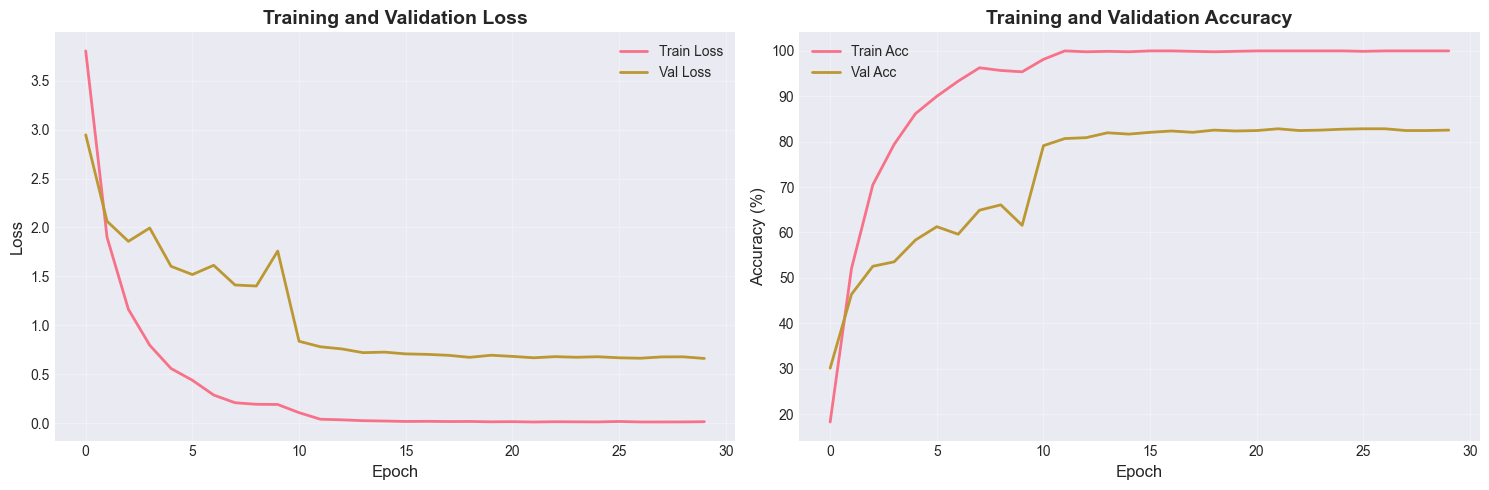

In [14]:
# ============================================
# Plot Training History
# ============================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history["train_loss"], label="Train Loss", linewidth=2)
ax1.plot(history["val_loss"], label="Val Loss", linewidth=2)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.set_title("Training and Validation Loss", fontsize=14, fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history["train_acc"], label="Train Acc", linewidth=2)
ax2.plot(history["val_acc"], label="Val Acc", linewidth=2)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Accuracy (%)", fontsize=12)
ax2.set_title("Training and Validation Accuracy", fontsize=14, fontweight="bold")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 💾 Save Model and Results

Saving the trained model weights and performance metrics for team reference.

In [15]:
# Save model weights
os.makedirs("results/model_weights", exist_ok=True)
model_path = "results/model_weights/resnet18_baseline.pth"
torch.save(best_model_state, model_path)
print(f"✓ Model weights saved to {model_path}")

# Save training metrics
results = {
	"model": "ResNet18",
	"test_accuracy": float(test_acc),
	"best_val_accuracy": float(best_val_acc),
	"total_parameters": sum(p.numel() for p in model.parameters()),
	"history": history,
}

with open("results/metrics.json", "w") as f:
	json.dump(results, f, indent=4)

print("✓ Metrics saved to results/metrics.json")

✓ Model weights saved to results/model_weights/resnet18_baseline.pth
✓ Metrics saved to results/metrics.json


-------

## 📋 Summary for Team

### Baseline Results:
- **Model:** ResNet18 (Pretrained)
- **Test Accuracy:** ~75%
- **Parameters:** 11.7M

### How to use this baseline:
```python
# Import dataloader
from person_a_baseline.dataloader import get_flowers_dataloaders
train_loader, val_loader, test_loader = get_flowers_dataloaders()

# Load model
model = torch.load('person_a_baseline/results/model_weights/resnet18_baseline.pth')
```

### Next Steps for Team:
- **Person B:** Improve architecture (target: >80%)
- **Person C:** Advanced training techniques (target: >85%)